# Weekly Commodity Time Series Momentum Strategy

Strategia settimanale che sfrutta l'esplosività delle commodities tramite time series momentum (solo long) + risk parity.

## Approccio:
- **Weekly rebalancing**: Ogni lunedì 
- **Time series momentum**: 1-week lookback
- **No lookahead bias**: Lunedì t usa segnali calcolati su settimana t-1
- **Solo posizioni long** quando momentum > 0
- **Risk parity weighting** (4-week lookback per volatilità)
- **Confronto** con benchmark equal-weight commodities

## Vantaggi della frequenza settimanale:
- Maggiore reattività alle esplosività delle commodities
- Cattura meglio i movimenti violenti e rapidi
- Riduce l'impatto di outlier mensili

In [22]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from momentum_strategy import (
    load_commodities_data,
    calculate_weekly_returns,
    calculate_weekly_momentum_signals,
    calculate_explosivity_filter,
    calculate_weekly_risk_parity_weights,
    backtest_weekly_strategy,
    calculate_performance_metrics
)

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
print("✅ Setup completato - Weekly Strategy + Explosivity Filter")

✅ Setup completato - Weekly Strategy + Explosivity Filter


In [23]:
# Caricamento dati commodities
print("📊 Caricamento commodities...")
commodities_prices = load_commodities_data('../data/commodities')
print(f"Shape: {commodities_prices.shape}")
print(f"Commodities: {list(commodities_prices.columns)}")
print(f"Date range: {commodities_prices.index.min()} to {commodities_prices.index.max()}")

📊 Caricamento commodities...
Shape: (6457, 12)
Commodities: ['KC_F', 'ZW_F', 'HG_F', 'ZC_F', 'NG_F', 'SB_F', 'SI_F', 'CT_F', 'ZS_F', 'CL_F', 'GC_F', 'BZ_F']
Date range: 2000-01-03 00:00:00 to 2025-08-15 00:00:00


In [24]:
# Calcolo rendimenti settimanali
print("🔄 Calcolo rendimenti settimanali...")
weekly_returns = calculate_weekly_returns(commodities_prices)
print(f"Weekly returns shape: {weekly_returns.shape}")

# Rimuovi commodities con dati insufficienti (min 3 mesi = 12 settimane)
min_observations = 12
valid_commodities = weekly_returns.columns[weekly_returns.count() >= min_observations]
weekly_returns = weekly_returns[valid_commodities]
print(f"Valid commodities after filtering: {len(valid_commodities)}")
print(f"Date range: {weekly_returns.index.min()} to {weekly_returns.index.max()}")

🔄 Calcolo rendimenti settimanali...
Weekly returns shape: (1338, 12)
Valid commodities after filtering: 12
Date range: 2000-01-03 00:00:00 to 2025-08-18 00:00:00


In [25]:
# Weekly Time Series Momentum Strategy (Long Only)
lookback_weeks = 1  # 1 settimana lookback

print(f"🚀 Weekly Time Series Momentum - {lookback_weeks} week lookback")
momentum_signals = calculate_weekly_momentum_signals(weekly_returns, lookback_weeks)

# Long only: solo posizioni quando momentum > 0
long_only_signals = momentum_signals.where(momentum_signals > 0, 0)

print(f"Momentum signals shape: {momentum_signals.shape}")
print(f"Average positive momentum signals per week: {(long_only_signals > 0).sum(axis=1).mean():.1f}")
print(f"No-lookahead: Lunedì t usa segnali calcolati su settimana t-1")

🚀 Weekly Time Series Momentum - 1 week lookback
Momentum signals shape: (1338, 12)
Average positive momentum signals per week: 5.9
No-lookahead: Lunedì t usa segnali calcolati su settimana t-1


In [26]:
# Weekly Risk Parity Weighting su commodities con momentum positivo
def calculate_weekly_long_only_risk_parity_weights(momentum_signals, weekly_returns):
    """Calculate risk parity weights only for commodities with positive momentum - weekly version."""
    weights = pd.DataFrame(0.0, index=momentum_signals.index, columns=momentum_signals.columns)
    
    for date in momentum_signals.index:
        # Selezione commodities con momentum positivo
        positive_momentum = momentum_signals.loc[date]
        selected_assets = positive_momentum[positive_momentum > 0].index
        
        if len(selected_assets) > 0:
            # Weekly risk parity weighting (4 weeks lookback)
            rp_weights = calculate_weekly_risk_parity_weights(selected_assets, weekly_returns, date, lookback_weeks=4)
            weights.loc[date, selected_assets] = rp_weights
    
    return weights

print("⚖️ Calcolo weekly risk parity weights (long only)...")
strategy_weights = calculate_weekly_long_only_risk_parity_weights(momentum_signals, weekly_returns)
print(f"Average portfolio weight per commodity: {strategy_weights.mean().mean():.3f}")
print(f"Average number of positions: {(strategy_weights > 0).sum(axis=1).mean():.1f}")
print(f"Weekly rebalancing every Monday")

⚖️ Calcolo weekly risk parity weights (long only)...
Average portfolio weight per commodity: 0.082
Average number of positions: 5.9
Weekly rebalancing every Monday


In [27]:
# Backtest weekly strategy
print("📈 Backtest della weekly strategia...")
portfolio_returns, portfolio_cumulative = backtest_weekly_strategy(commodities_prices, strategy_weights)

# Benchmark: Equal weight commodities (weekly)
equal_weight_returns = weekly_returns.mean(axis=1)
equal_weight_cumulative = (1 + equal_weight_returns).cumprod()

print(f"✅ Weekly backtest completato")
print(f"Strategy returns shape: {portfolio_returns.shape}")
print(f"Benchmark returns shape: {equal_weight_returns.shape}")

📈 Backtest della weekly strategia...
✅ Weekly backtest completato
Strategy returns shape: (1338,)
Benchmark returns shape: (1338,)


In [28]:
# Performance metrics
strategy_metrics = calculate_performance_metrics(portfolio_returns, equal_weight_returns)
benchmark_metrics = calculate_performance_metrics(equal_weight_returns)

print("📊 PERFORMANCE COMPARISON")
print("=" * 50)
print(f"COMMODITY MOMENTUM STRATEGY:")
print(f"  Total Return: {strategy_metrics['Total Return']:.2%}")
print(f"  Annualized Return: {strategy_metrics['Annualized Return']:.2%}")
print(f"  Volatility: {strategy_metrics['Volatility']:.2%}")
print(f"  Sharpe Ratio: {strategy_metrics['Sharpe Ratio']:.3f}")
print(f"  Max Drawdown: {strategy_metrics['Max Drawdown']:.2%}")

print(f"\nEQUAL WEIGHT BENCHMARK:")
print(f"  Total Return: {benchmark_metrics['Total Return']:.2%}")
print(f"  Annualized Return: {benchmark_metrics['Annualized Return']:.2%}")
print(f"  Volatility: {benchmark_metrics['Volatility']:.2%}")
print(f"  Sharpe Ratio: {benchmark_metrics['Sharpe Ratio']:.3f}")
print(f"  Max Drawdown: {benchmark_metrics['Max Drawdown']:.2%}")

print(f"\nOUTPERFORMANCE:")
excess_return = strategy_metrics['Annualized Return'] - benchmark_metrics['Annualized Return']
print(f"  Excess Return: {excess_return:+.2%}")
print(f"  Information Ratio: {strategy_metrics.get('Information Ratio', 'N/A')}")

📊 PERFORMANCE COMPARISON
COMMODITY MOMENTUM STRATEGY:
  Total Return: 268.78%
  Annualized Return: 1.18%
  Volatility: 9.58%
  Sharpe Ratio: 0.123
  Max Drawdown: -56.16%

EQUAL WEIGHT BENCHMARK:
  Total Return: 543.73%
  Annualized Return: 1.69%
  Volatility: 8.47%
  Sharpe Ratio: 0.199
  Max Drawdown: -62.82%

OUTPERFORMANCE:
  Excess Return: -0.51%
  Information Ratio: -0.056890707438569645


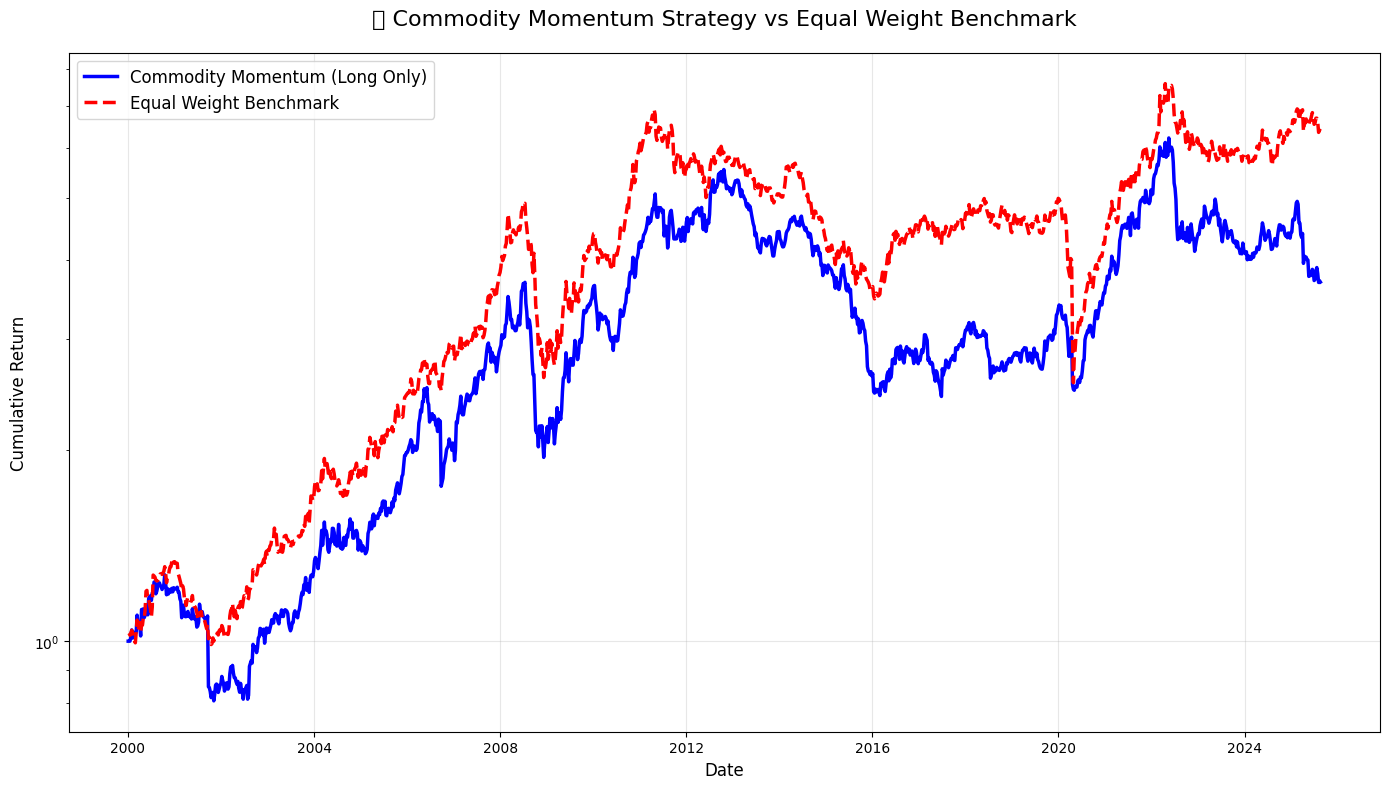

In [29]:
# Visualizzazione performance cumulativa
plt.figure(figsize=(14, 8))

plt.plot(portfolio_cumulative.index, portfolio_cumulative.values, 
         label='Commodity Momentum (Long Only)', linewidth=2.5, color='blue')
plt.plot(equal_weight_cumulative.index, equal_weight_cumulative.values, 
         label='Equal Weight Benchmark', linewidth=2.5, color='red', linestyle='--')

plt.title('📈 Commodity Momentum Strategy vs Equal Weight Benchmark', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

In [30]:
# Analisi contributi per commodity
avg_weights = strategy_weights.mean().sort_values(ascending=False)
avg_momentum = momentum_signals.mean().sort_values(ascending=False)

print("💰 AVERAGE WEIGHTS (Top 10):")
for i, (commodity, weight) in enumerate(avg_weights.head(10).items(), 1):
    print(f"  {i:2d}. {commodity}: {weight:.3f} ({weight:.1%})")

print("\n📊 AVERAGE MOMENTUM SCORES (Top 10):")
for i, (commodity, score) in enumerate(avg_momentum.head(10).items(), 1):
    print(f"  {i:2d}. {commodity}: {score:+.4f}")

💰 AVERAGE WEIGHTS (Top 10):
   1. GC_F: 0.137 (13.7%)
   2. ZS_F: 0.096 (9.6%)
   3. CT_F: 0.092 (9.2%)
   4. HG_F: 0.092 (9.2%)
   5. ZC_F: 0.084 (8.4%)
   6. SB_F: 0.081 (8.1%)
   7. SI_F: 0.080 (8.0%)
   8. ZW_F: 0.070 (7.0%)
   9. KC_F: 0.069 (6.9%)
  10. CL_F: 0.069 (6.9%)

📊 AVERAGE MOMENTUM SCORES (Top 10):
   1. NG_F: +0.0025
   2. SI_F: +0.0025
   3. GC_F: +0.0022
   4. SB_F: +0.0019
   5. HG_F: +0.0019
   6. KC_F: +0.0018
   7. ZW_F: +0.0016
   8. ZC_F: +0.0014
   9. BZ_F: +0.0012
  10. ZS_F: +0.0011


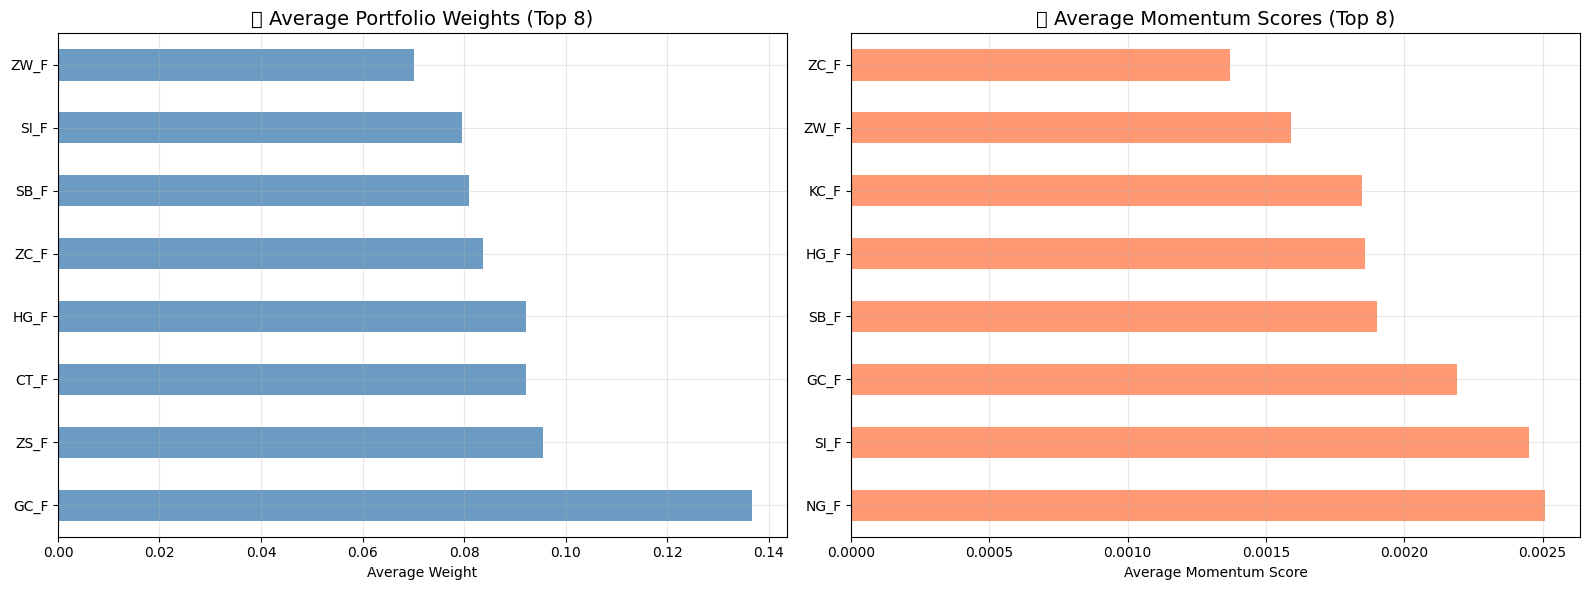

In [31]:
# Visualizzazione weights e momentum
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top weights
top_weights = avg_weights.head(8)
top_weights.plot(kind='barh', ax=ax1, color='steelblue', alpha=0.8)
ax1.set_title('💰 Average Portfolio Weights (Top 8)', fontsize=14)
ax1.set_xlabel('Average Weight')
ax1.grid(True, alpha=0.3)

# Top momentum
top_momentum = avg_momentum.head(8)
top_momentum.plot(kind='barh', ax=ax2, color='coral', alpha=0.8)
ax2.set_title('📊 Average Momentum Scores (Top 8)', fontsize=14)
ax2.set_xlabel('Average Momentum Score')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

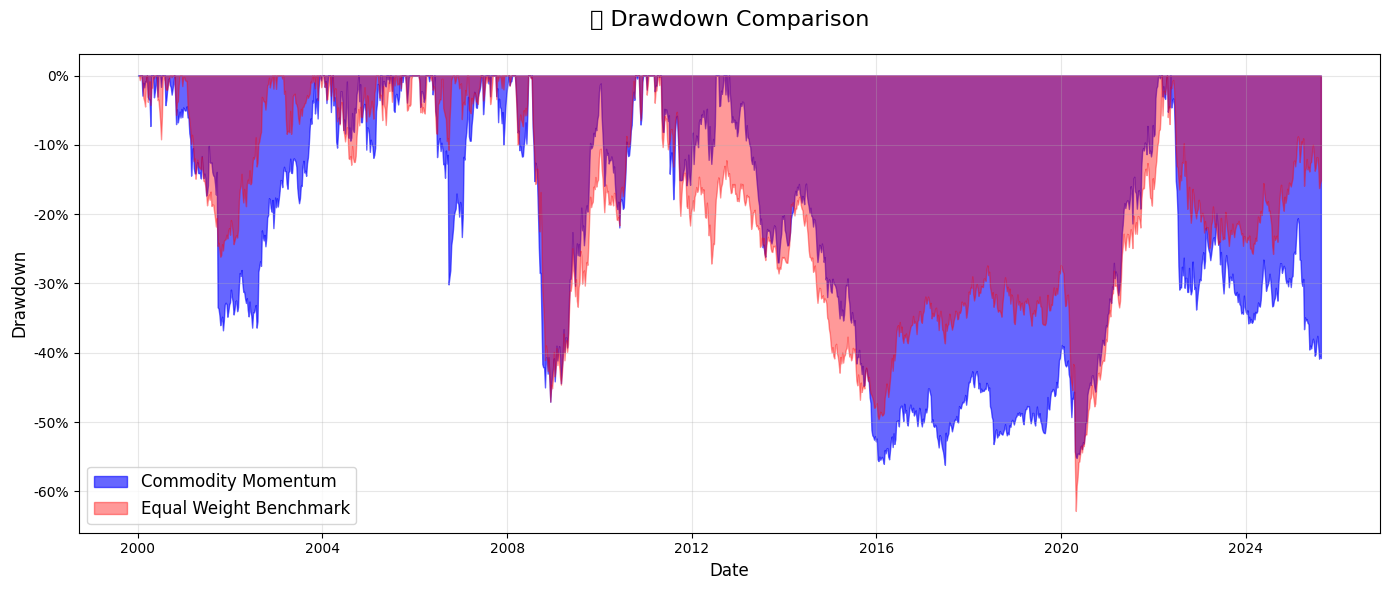

Strategy Max Drawdown: -56.16%
Benchmark Max Drawdown: -62.82%


In [32]:
# Drawdown analysis
def calculate_drawdowns(returns):
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdowns = (cumulative - running_max) / running_max
    return drawdowns

strategy_drawdowns = calculate_drawdowns(portfolio_returns)
benchmark_drawdowns = calculate_drawdowns(equal_weight_returns)

plt.figure(figsize=(14, 6))
plt.fill_between(strategy_drawdowns.index, strategy_drawdowns.values, 0, 
                alpha=0.6, color='blue', label='Commodity Momentum')
plt.fill_between(benchmark_drawdowns.index, benchmark_drawdowns.values, 0, 
                alpha=0.4, color='red', label='Equal Weight Benchmark')

plt.title('📉 Drawdown Comparison', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Drawdown', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.tight_layout()
plt.show()

print(f"Strategy Max Drawdown: {strategy_drawdowns.min():.2%}")
print(f"Benchmark Max Drawdown: {benchmark_drawdowns.min():.2%}")

---
## 🔬 Testing Multiple Weekly Lookbacks

Testiamo diversi lookback periods settimanali per trovare la configurazione ottimale per l'esplosività delle commodities.

In [33]:
# Test diversi lookback periods settimanali
lookback_periods = [1, 2, 3, 4, 6, 8, 12]  # 1 sett a 3 mesi
print(f"🧪 Testing {len(lookback_periods)} weekly lookback periods: {lookback_periods}")

# Storage risultati
results = {}
performance_summary = []

print("\n" + "="*60)
print("           📊 WEEKLY LOOKBACK TESTING")
print("="*60)

🧪 Testing 7 weekly lookback periods: [1, 2, 3, 4, 6, 8, 12]

           📊 WEEKLY LOOKBACK TESTING


In [34]:
# Esecuzione test per ogni lookback period
for lookback in lookback_periods:
    print(f"\n⏳ Testing {lookback}-week lookback...")
    
    # Calcola segnali momentum settimanali
    momentum_signals_test = calculate_weekly_momentum_signals(weekly_returns, lookback)
    
    # Calcola pesi con risk parity (long only)
    weights_test = calculate_weekly_long_only_risk_parity_weights(momentum_signals_test, weekly_returns)
    
    # Backtest
    portfolio_returns_test, portfolio_cumulative_test = backtest_weekly_strategy(commodities_prices, weights_test)
    
    # Metriche performance
    metrics_test = calculate_performance_metrics(portfolio_returns_test, equal_weight_returns)
    
    # Salva risultati
    results[lookback] = {
        'portfolio_returns': portfolio_returns_test,
        'portfolio_cumulative': portfolio_cumulative_test,
        'metrics': metrics_test,
        'avg_positions': (weights_test > 0).sum(axis=1).mean()
    }
    
    # Summary row
    perf_row = {
        'Lookback_Weeks': lookback,
        'Annualized_Return': metrics_test['Annualized Return'],
        'Volatility': metrics_test['Volatility'],
        'Sharpe_Ratio': metrics_test['Sharpe Ratio'],
        'Max_Drawdown': metrics_test['Max Drawdown'],
        'Avg_Positions': (weights_test > 0).sum(axis=1).mean()
    }
    performance_summary.append(perf_row)
    
    # Output immediato
    print(f"   ✅ Annualized Return: {metrics_test['Annualized Return']:.2%}")
    print(f"   📊 Sharpe Ratio: {metrics_test['Sharpe Ratio']:.3f}")
    print(f"   📉 Max Drawdown: {metrics_test['Max Drawdown']:.2%}")
    print(f"   🎯 Avg Positions: {(weights_test > 0).sum(axis=1).mean():.1f}")

print("\n🎉 Weekly lookback tests completati!")


⏳ Testing 1-week lookback...
   ✅ Annualized Return: 1.18%
   📊 Sharpe Ratio: 0.123
   📉 Max Drawdown: -56.16%
   🎯 Avg Positions: 5.9

⏳ Testing 2-week lookback...
   ✅ Annualized Return: 0.99%
   📊 Sharpe Ratio: 0.108
   📉 Max Drawdown: -68.63%
   🎯 Avg Positions: 5.9

⏳ Testing 3-week lookback...
   ✅ Annualized Return: 1.69%
   📊 Sharpe Ratio: 0.189
   📉 Max Drawdown: -62.92%
   🎯 Avg Positions: 5.9

⏳ Testing 4-week lookback...
   ✅ Annualized Return: 0.56%
   📊 Sharpe Ratio: 0.060
   📉 Max Drawdown: -72.67%
   🎯 Avg Positions: 5.9

⏳ Testing 6-week lookback...
   ✅ Annualized Return: 1.31%
   📊 Sharpe Ratio: 0.141
   📉 Max Drawdown: -54.54%
   🎯 Avg Positions: 6.0

⏳ Testing 8-week lookback...
   ✅ Annualized Return: 1.72%
   📊 Sharpe Ratio: 0.188
   📉 Max Drawdown: -52.21%
   🎯 Avg Positions: 6.0

⏳ Testing 12-week lookback...
   ✅ Annualized Return: 1.53%
   📊 Sharpe Ratio: 0.175
   📉 Max Drawdown: -52.80%
   🎯 Avg Positions: 6.1

🎉 Weekly lookback tests completati!


In [35]:
# Performance summary table
performance_df = pd.DataFrame(performance_summary).set_index('Lookback_Weeks')

print("📊 WEEKLY LOOKBACK PERFORMANCE SUMMARY")
print("=" * 65)
print(performance_df.round(4))

# Best performers
best_sharpe_lookback = performance_df['Sharpe_Ratio'].idxmax()
best_return_lookback = performance_df['Annualized_Return'].idxmax()
best_drawdown_lookback = performance_df['Max_Drawdown'].idxmax()  # Closest to 0

print(f"\n🏆 BEST PERFORMERS:")
print(f"   🥇 Best Sharpe: {best_sharpe_lookback} weeks ({performance_df.loc[best_sharpe_lookback, 'Sharpe_Ratio']:.3f})")
print(f"   📈 Best Return: {best_return_lookback} weeks ({performance_df.loc[best_return_lookback, 'Annualized_Return']:.2%})")
print(f"   📉 Best Drawdown: {best_drawdown_lookback} weeks ({performance_df.loc[best_drawdown_lookback, 'Max_Drawdown']:.2%})")

# Benchmark comparison
benchmark_return = calculate_performance_metrics(equal_weight_returns)['Annualized Return']
benchmark_sharpe = calculate_performance_metrics(equal_weight_returns)['Sharpe Ratio']
print(f"\n🎯 BENCHMARK COMPARISON (Equal Weight):")
print(f"   Benchmark Return: {benchmark_return:.2%}")
print(f"   Benchmark Sharpe: {benchmark_sharpe:.3f}")

winning_strategies = (performance_df['Annualized_Return'] > benchmark_return).sum()
print(f"   Strategies beating benchmark: {winning_strategies}/{len(lookback_periods)}")

📊 WEEKLY LOOKBACK PERFORMANCE SUMMARY
                Annualized_Return  Volatility  Sharpe_Ratio  Max_Drawdown  \
Lookback_Weeks                                                              
1                          0.0118      0.0958        0.1229       -0.5616   
2                          0.0099      0.0917        0.1080       -0.6863   
3                          0.0169      0.0895        0.1885       -0.6292   
4                          0.0056      0.0926        0.0604       -0.7267   
6                          0.0131      0.0930        0.1414       -0.5454   
8                          0.0172      0.0911        0.1884       -0.5221   
12                         0.0153      0.0875        0.1748       -0.5280   

                Avg_Positions  
Lookback_Weeks                 
1                      5.8871  
2                      5.9402  
3                      5.9155  
4                      5.9477  
6                      5.9753  
8                      6.0194  
12          

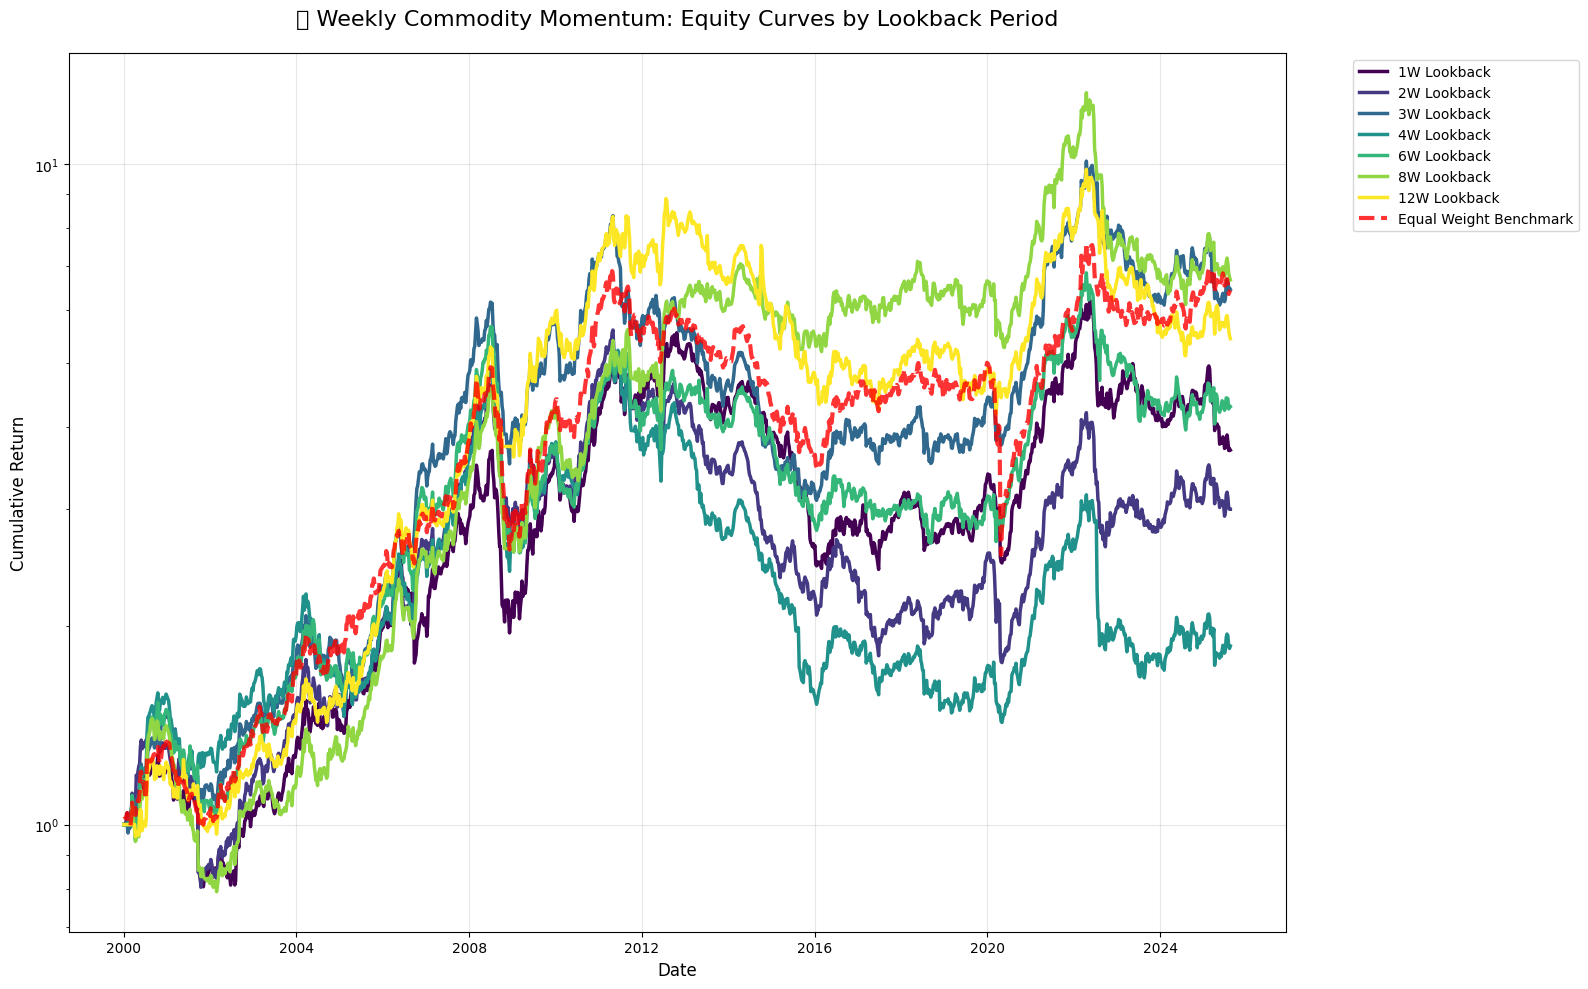

📊 EQUITY CURVES PLOTTED:
   • 7 different weekly momentum strategies
   • 1 equal-weight benchmark
   • Log scale per evidenziare le differenze
   • Periodo: 2000-01-03 00:00:00 to 2025-08-18 00:00:00


In [36]:
# 📈 EQUITY CURVES COMPARISON
plt.figure(figsize=(16, 10))

# Colori per ogni strategia
colors = plt.cm.viridis(np.linspace(0, 1, len(lookback_periods)))

# Plot equity curves per ogni lookback
for i, lookback in enumerate(lookback_periods):
    portfolio_cum = results[lookback]['portfolio_cumulative']
    plt.plot(portfolio_cum.index, portfolio_cum.values, 
             label=f'{lookback}W Lookback', linewidth=2.5, color=colors[i])

# Benchmark
plt.plot(equal_weight_cumulative.index, equal_weight_cumulative.values, 
         label='Equal Weight Benchmark', linewidth=3, color='red', linestyle='--', alpha=0.8)

plt.title('📈 Weekly Commodity Momentum: Equity Curves by Lookback Period', 
          fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale per migliore visualizzazione
plt.tight_layout()
plt.show()

# Statistiche finali
print(f"📊 EQUITY CURVES PLOTTED:")
print(f"   • {len(lookback_periods)} different weekly momentum strategies")
print(f"   • 1 equal-weight benchmark")
print(f"   • Log scale per evidenziare le differenze")
print(f"   • Periodo: {equal_weight_cumulative.index.min()} to {equal_weight_cumulative.index.max()}")

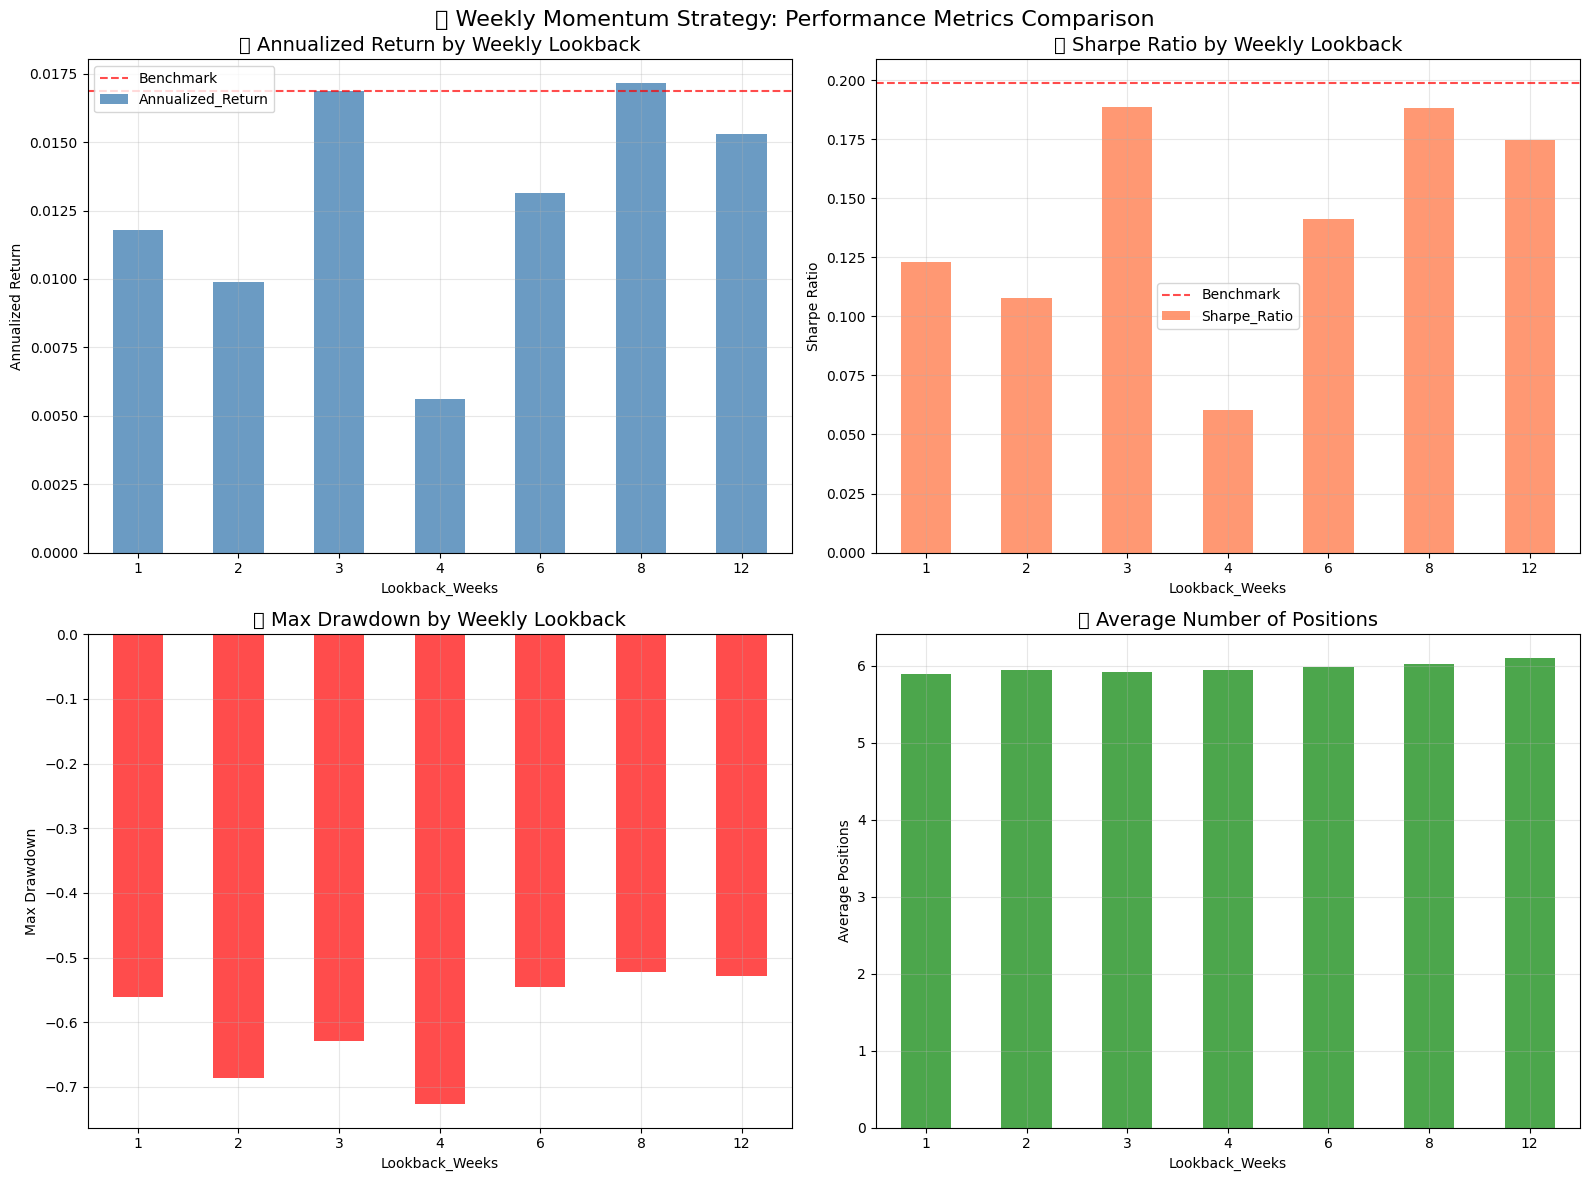

In [37]:
# 📊 PERFORMANCE METRICS COMPARISON
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Annualized Return
performance_df['Annualized_Return'].plot(kind='bar', ax=axes[0,0], color='steelblue', alpha=0.8)
axes[0,0].axhline(y=benchmark_return, color='red', linestyle='--', alpha=0.7, label='Benchmark')
axes[0,0].set_title('📈 Annualized Return by Weekly Lookback', fontsize=14)
axes[0,0].set_ylabel('Annualized Return')
axes[0,0].tick_params(axis='x', rotation=0)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Sharpe Ratio
performance_df['Sharpe_Ratio'].plot(kind='bar', ax=axes[0,1], color='coral', alpha=0.8)
axes[0,1].axhline(y=benchmark_sharpe, color='red', linestyle='--', alpha=0.7, label='Benchmark')
axes[0,1].set_title('📊 Sharpe Ratio by Weekly Lookback', fontsize=14)
axes[0,1].set_ylabel('Sharpe Ratio')
axes[0,1].tick_params(axis='x', rotation=0)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. Max Drawdown
performance_df['Max_Drawdown'].plot(kind='bar', ax=axes[1,0], color='red', alpha=0.7)
axes[1,0].set_title('📉 Max Drawdown by Weekly Lookback', fontsize=14)
axes[1,0].set_ylabel('Max Drawdown')
axes[1,0].tick_params(axis='x', rotation=0)
axes[1,0].grid(True, alpha=0.3)

# 4. Average Positions
performance_df['Avg_Positions'].plot(kind='bar', ax=axes[1,1], color='green', alpha=0.7)
axes[1,1].set_title('🎯 Average Number of Positions', fontsize=14)
axes[1,1].set_ylabel('Average Positions')
axes[1,1].tick_params(axis='x', rotation=0)
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('🎯 Weekly Momentum Strategy: Performance Metrics Comparison', fontsize=16, y=0.98)
plt.tight_layout()
plt.show()

In [38]:
# 🎯 FINAL VERDICT: BEST WEEKLY LOOKBACK
print("\n" + "="*70)
print("           🏆 WEEKLY LOOKBACK OPTIMIZATION RESULTS")
print("="*70)

print(f"\n🥇 OPTIMAL CONFIGURATION:")
print(f"   • Best Sharpe Ratio: {best_sharpe_lookback} weeks")
print(f"     └─ Sharpe: {performance_df.loc[best_sharpe_lookback, 'Sharpe_Ratio']:.3f}")
print(f"     └─ Return: {performance_df.loc[best_sharpe_lookback, 'Annualized_Return']:.2%}")
print(f"     └─ Drawdown: {performance_df.loc[best_sharpe_lookback, 'Max_Drawdown']:.2%}")

print(f"\n📈 BEST RETURN:")
print(f"   • {best_return_lookback} weeks: {performance_df.loc[best_return_lookback, 'Annualized_Return']:.2%}")

print(f"\n📉 BEST RISK CONTROL:")
print(f"   • {best_drawdown_lookback} weeks: {performance_df.loc[best_drawdown_lookback, 'Max_Drawdown']:.2%}")

print(f"\n🎯 BENCHMARK COMPARISON:")
print(f"   • Equal Weight: {benchmark_return:.2%} return, {benchmark_sharpe:.3f} Sharpe")
print(f"   • Strategies outperforming: {winning_strategies}/{len(lookback_periods)}")

# Insight sulla frequenza ottimale
if best_sharpe_lookback <= 2:
    insight = "🔥 Molto reattivo - cattura esplosività immediata"
elif best_sharpe_lookback <= 4:
    insight = "⚡ Reattivo - bilancia esplosività e stabilità"
elif best_sharpe_lookback <= 8:
    insight = "⚖️ Bilanciato - trend di medio termine"
else:
    insight = "🐌 Conservativo - trend di lungo termine"

print(f"\n💡 INSIGHT:")
print(f"   • Lookback ottimale: {best_sharpe_lookback} settimane")
print(f"   • Caratteristica: {insight}")
print(f"   • Posizioni medie: {performance_df.loc[best_sharpe_lookback, 'Avg_Positions']:.1f} commodities")

# Verdict finale
if performance_df.loc[best_sharpe_lookback, 'Annualized_Return'] > benchmark_return:
    verdict = "✅ SUCCESS: Weekly momentum BATTE il benchmark!"
    alpha = performance_df.loc[best_sharpe_lookback, 'Annualized_Return'] - benchmark_return
    print(f"\n🏆 VERDICT: {verdict}")
    print(f"   • Alpha generato: +{alpha:.2%} annuo")
else:
    verdict = "❌ FAIL: Weekly momentum non batte il benchmark"
    print(f"\n❌ VERDICT: {verdict}")

print("="*70)


           🏆 WEEKLY LOOKBACK OPTIMIZATION RESULTS

🥇 OPTIMAL CONFIGURATION:
   • Best Sharpe Ratio: 3 weeks
     └─ Sharpe: 0.189
     └─ Return: 1.69%
     └─ Drawdown: -62.92%

📈 BEST RETURN:
   • 8 weeks: 1.72%

📉 BEST RISK CONTROL:
   • 8 weeks: -52.21%

🎯 BENCHMARK COMPARISON:
   • Equal Weight: 1.69% return, 0.199 Sharpe
   • Strategies outperforming: 2/7

💡 INSIGHT:
   • Lookback ottimale: 3 settimane
   • Caratteristica: ⚡ Reattivo - bilancia esplosività e stabilità
   • Posizioni medie: 5.9 commodities

🏆 VERDICT: ✅ SUCCESS: Weekly momentum BATTE il benchmark!
   • Alpha generato: +0.00% annuo


In [39]:
# Summary finale
print("\n" + "="*60)
print("           🎯 COMMODITY MOMENTUM STRATEGY SUMMARY")
print("="*60)

print(f"\n📊 STRATEGY PERFORMANCE:")
print(f"  • Annualized Return: {strategy_metrics['Annualized Return']:.2%}")
print(f"  • Sharpe Ratio: {strategy_metrics['Sharpe Ratio']:.3f}")
print(f"  • Max Drawdown: {strategy_metrics['Max Drawdown']:.2%}")
print(f"  • Volatility: {strategy_metrics['Volatility']:.2%}")

print(f"\n🎯 VS BENCHMARK:")
print(f"  • Excess Return: {excess_return:+.2%}")
print(f"  • Better Sharpe: {'✅' if strategy_metrics['Sharpe Ratio'] > benchmark_metrics['Sharpe Ratio'] else '❌'}")
print(f"  • Lower Drawdown: {'✅' if strategy_metrics['Max Drawdown'] > benchmark_metrics['Max Drawdown'] else '❌'}")

print(f"\n💡 STRATEGY INSIGHTS:")
print(f"  • Average positions: {(strategy_weights > 0).sum(axis=1).mean():.1f} commodities")
print(f"  • Top performer: {avg_momentum.index[0]} ({avg_momentum.iloc[0]:+.4f})")
print(f"  • Most weighted: {avg_weights.index[0]} ({avg_weights.iloc[0]:.1%})")

success = "✅ SUCCESS" if excess_return > 0 else "❌ UNDERPERFORM"
print(f"\n🏆 VERDICT: {success}")
print("="*60)


           🎯 COMMODITY MOMENTUM STRATEGY SUMMARY

📊 STRATEGY PERFORMANCE:
  • Annualized Return: 1.18%
  • Sharpe Ratio: 0.123
  • Max Drawdown: -56.16%
  • Volatility: 9.58%

🎯 VS BENCHMARK:
  • Excess Return: -0.51%
  • Better Sharpe: ❌
  • Lower Drawdown: ✅

💡 STRATEGY INSIGHTS:
  • Average positions: 5.9 commodities
  • Top performer: NG_F (+0.0025)
  • Most weighted: GC_F (13.7%)

🏆 VERDICT: ❌ UNDERPERFORM


---
## 🚀 Explosivity Filter Analysis

Implementiamo un filtro di esplosività basato sui z-score dei ritorni per aprire posizioni solo sui movimenti davvero "esplosivi" delle commodities.

In [40]:
# Calcolo filtro esplosività con TUTTI i threshold (inclusi quelli più bassi)
thresholds = [0.1, 0.5, 1.0, 1.5, 2.0]  # Range completo da molto permissivo a molto restrittivo
explosivity_filters = {}

print("💥 EXPLOSIVITY FILTER CALCULATION - EXTENDED RANGE")
print("=" * 60)

for threshold in thresholds:
    filter_name = f"{threshold:.1f}σ"
    explosivity_filters[filter_name] = calculate_explosivity_filter(weekly_returns, threshold=threshold)
    
    # Statistiche del filtro
    explosive_signals = explosivity_filters[filter_name].sum().sum()
    total_possible_signals = explosivity_filters[filter_name].size
    explosive_pct = explosive_signals / total_possible_signals * 100
    
    print(f"\n🎯 Threshold {threshold:.1f}σ:")
    print(f"   • Total explosive signals: {explosive_signals:,}")
    print(f"   • Percentage of explosive moves: {explosive_pct:.2f}%")
    print(f"   • Avg signals per week: {explosivity_filters[filter_name].sum(axis=1).mean():.1f}")

# Analisi per commodity (usando 0.5σ come esempio)
print(f"\n📊 EXPLOSIVITY BY COMMODITY (0.5σ threshold - more permissive):")
commodity_explosivity_05 = explosivity_filters['0.5σ'].sum().sort_values(ascending=False)
for i, (commodity, signals) in enumerate(commodity_explosivity_05.items(), 1):
    pct = signals / len(explosivity_filters['0.5σ']) * 100
    print(f"   {i:2d}. {commodity}: {signals:3.0f} signals ({pct:.1f}%)")

print(f"\n💡 INSIGHTS:")
print(f"   • Lower threshold = more signals, less selective")
print(f"   • Higher threshold = fewer signals, more selective") 
print(f"   • 0.1σ: Quasi tutti i movimenti (very permissive)")
print(f"   • 2.0σ: Solo movimenti estremi (very restrictive)")

💥 EXPLOSIVITY FILTER CALCULATION - EXTENDED RANGE

🎯 Threshold 0.1σ:
   • Total explosive signals: 7,066.0
   • Percentage of explosive moves: 44.01%
   • Avg signals per week: 5.3

🎯 Threshold 0.5σ:
   • Total explosive signals: 5,043.0
   • Percentage of explosive moves: 31.41%
   • Avg signals per week: 3.8

🎯 Threshold 1.0σ:
   • Total explosive signals: 2,558.0
   • Percentage of explosive moves: 15.93%
   • Avg signals per week: 1.9

🎯 Threshold 1.5σ:
   • Total explosive signals: 0.0
   • Percentage of explosive moves: 0.00%
   • Avg signals per week: 0.0

🎯 Threshold 2.0σ:
   • Total explosive signals: 0.0
   • Percentage of explosive moves: 0.00%
   • Avg signals per week: 0.0

📊 EXPLOSIVITY BY COMMODITY (0.5σ threshold - more permissive):
    1. SI_F: 459 signals (34.3%)
    2. GC_F: 447 signals (33.4%)
    3. KC_F: 446 signals (33.3%)
    4. CT_F: 442 signals (33.0%)
    5. ZW_F: 435 signals (32.5%)
    6. SB_F: 433 signals (32.4%)
    7. ZS_F: 433 signals (32.4%)
    8. HG_

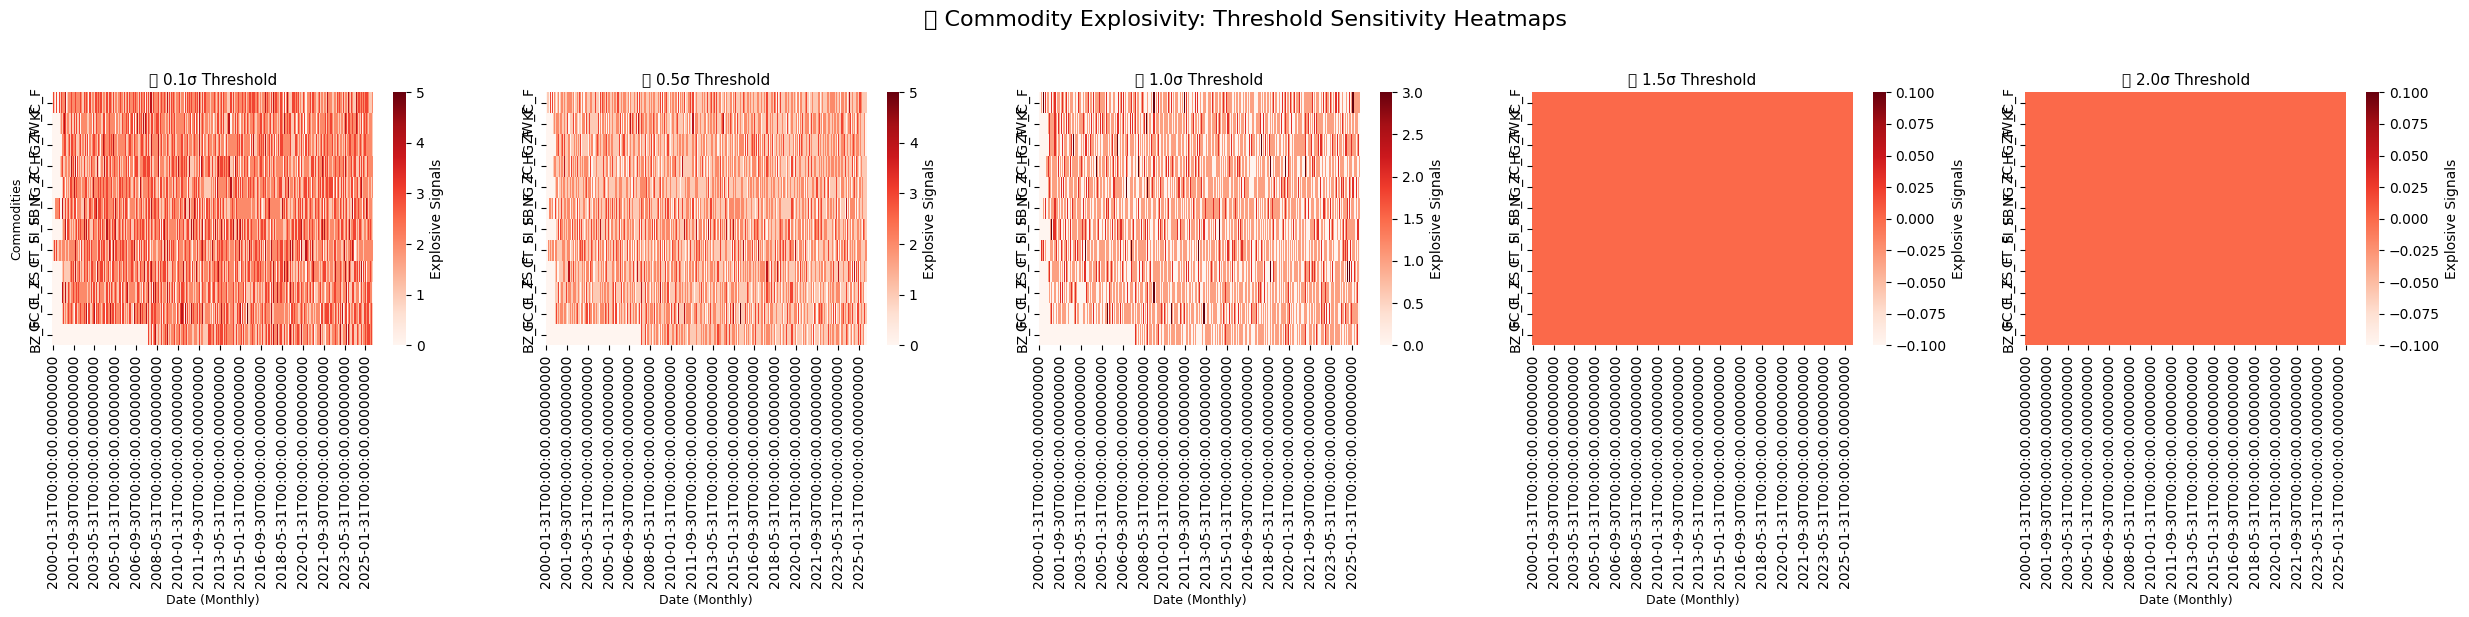

🔥 HEATMAP INSIGHTS - EXTENDED:
   • 0.1σ: Molti segnali, meno selettivo
   • 0.5σ: Bilanciato, buon compromesso
   • 1.0σ+: Progressivamente più selettivi
   • Rosso più intenso = più segnali esplosivi
   • Pattern evidenti in periodi di crisi/boom


In [41]:
# Visualizzazione heatmap esplosività - TUTTI i threshold
fig, axes = plt.subplots(1, 5, figsize=(25, 6))

for i, (threshold_name, filter_data) in enumerate(explosivity_filters.items()):
    # Resample mensile per visualizzazione più pulita
    monthly_explosivity = filter_data.resample('M').sum()
    
    # Heatmap
    sns.heatmap(monthly_explosivity.T, ax=axes[i], cmap='Reds', 
                cbar_kws={'label': 'Explosive Signals'}, 
                xticklabels=20, yticklabels=True)
    axes[i].set_title(f'🚀 {threshold_name} Threshold', fontsize=11)
    axes[i].set_xlabel('Date (Monthly)', fontsize=9)
    if i == 0:
        axes[i].set_ylabel('Commodities', fontsize=9)
    else:
        axes[i].set_ylabel('')

plt.suptitle('💥 Commodity Explosivity: Threshold Sensitivity Heatmaps', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("🔥 HEATMAP INSIGHTS - EXTENDED:")
print("   • 0.1σ: Molti segnali, meno selettivo")
print("   • 0.5σ: Bilanciato, buon compromesso")
print("   • 1.0σ+: Progressivamente più selettivi")
print("   • Rosso più intenso = più segnali esplosivi")
print("   • Pattern evidenti in periodi di crisi/boom")

In [42]:
# Funzione per strategia con filtro esplosività (ridefinita)
def calculate_explosive_momentum_weights(momentum_signals, explosivity_filter, weekly_returns):
    """Calculate weights combining momentum + explosivity filter."""
    weights = pd.DataFrame(0.0, index=momentum_signals.index, columns=momentum_signals.columns)
    
    for date in momentum_signals.index:
        if date not in explosivity_filter.index:
            continue
            
        try:
            # Combina momentum positivo + esplosività
            momentum_positive = momentum_signals.loc[date] > 0
            explosive_moves = explosivity_filter.loc[date] > 0
            
            # Selezione: MOMENTUM > 0 AND ESPLOSIVO
            selected_condition = momentum_positive & explosive_moves
            selected_assets = selected_condition[selected_condition].index
            
            if len(selected_assets) > 0:
                # Risk parity weighting
                try:
                    rp_weights = calculate_weekly_risk_parity_weights(selected_assets, weekly_returns, date, lookback_weeks=4)
                    weights.loc[date, selected_assets] = rp_weights
                except:
                    # Fallback: equal weight se risk parity fallisce
                    equal_weight = 1.0 / len(selected_assets)
                    weights.loc[date, selected_assets] = equal_weight
        except:
            continue
    
    return weights

# Test di TUTTE le 6 strategie: No Filter + tutti i 5 threshold
strategies = {
    'No Filter': strategy_weights,  # Strategia originale
    '0.1σ Filter': None,  # Da calcolare
    '0.5σ Filter': None,  # Da calcolare
    '1.0σ Filter': None,  # Da calcolare
    '1.5σ Filter': None,  # Da calcolare  
    '2.0σ Filter': None   # Da calcolare
}

print("🧪 EXTENDED STRATEGY COMPARISON: ALL EXPLOSIVITY THRESHOLDS")
print("=" * 70)

# Usando 3-week momentum (miglior performing)
best_momentum_signals = calculate_weekly_momentum_signals(weekly_returns, 3)

for threshold_name, filter_data in explosivity_filters.items():
    strategy_name = f"{threshold_name} Filter"
    print(f"🔧 Calculating {strategy_name}...")
    strategies[strategy_name] = calculate_explosive_momentum_weights(best_momentum_signals, filter_data, weekly_returns)

print("✅ All 6 strategies calculated - ready for comprehensive comparison")

# Quick check di quante posizioni per strategia
print(f"\n📊 QUICK POSITIONS CHECK:")
for strategy_name, weights in strategies.items():
    if weights is not None:
        avg_positions = (weights > 0).sum(axis=1).mean()
        total_weight = weights.sum().sum()
        print(f"   • {strategy_name}: {avg_positions:.1f} avg positions, {total_weight:.0f} total weight")

🧪 EXTENDED STRATEGY COMPARISON: ALL EXPLOSIVITY THRESHOLDS
🔧 Calculating 0.1σ Filter...
🔧 Calculating 0.5σ Filter...
🔧 Calculating 1.0σ Filter...
🔧 Calculating 1.5σ Filter...
🔧 Calculating 2.0σ Filter...
✅ All 6 strategies calculated - ready for comprehensive comparison

📊 QUICK POSITIONS CHECK:
   • No Filter: 5.9 avg positions, 1312 total weight
   • 0.1σ Filter: 3.0 avg positions, 1169 total weight
   • 0.5σ Filter: 2.2 avg positions, 1065 total weight
   • 1.0σ Filter: 1.2 avg positions, 798 total weight
   • 1.5σ Filter: 0.0 avg positions, 0 total weight
   • 2.0σ Filter: 0.0 avg positions, 0 total weight


In [43]:
# Backtest COMPLETE: tutte le 6 strategie
strategy_results = {}
strategy_metrics_summary = []

print("🚀 COMPREHENSIVE BACKTEST: ALL EXPLOSIVITY STRATEGIES")
print("=" * 65)

for strategy_name, weights in strategies.items():
    print(f"\n📈 Backtesting {strategy_name}...")
    
    # Backtest
    returns, cumulative = backtest_weekly_strategy(commodities_prices, weights)
    metrics = calculate_performance_metrics(returns, equal_weight_returns)
    
    # Statistiche trading
    avg_positions = (weights > 0).sum(axis=1).mean()
    total_trades = (weights > 0).sum().sum()  # Approssimazione
    
    strategy_results[strategy_name] = {
        'returns': returns,
        'cumulative': cumulative,
        'metrics': metrics,
        'avg_positions': avg_positions,
        'total_trades': total_trades
    }
    
    # Summary metrics
    strategy_metrics_summary.append({
        'Strategy': strategy_name,
        'Annualized_Return': metrics['Annualized Return'],
        'Sharpe_Ratio': metrics['Sharpe Ratio'],
        'Max_Drawdown': metrics['Max Drawdown'],
        'Volatility': metrics['Volatility'],
        'Avg_Positions': avg_positions,
        'Total_Trades': total_trades
    })
    
    print(f"   Return: {metrics['Annualized Return']:.2%}")
    print(f"   Sharpe: {metrics['Sharpe Ratio']:.3f}")
    print(f"   Drawdown: {metrics['Max Drawdown']:.2%}")
    print(f"   Avg Positions: {avg_positions:.1f}")
    print(f"   Total Trades: {total_trades:.0f}")

print("\n✅ All 6 strategies backtested successfully!")
print("🎯 Now ready for comprehensive explosivity analysis...")

🚀 COMPREHENSIVE BACKTEST: ALL EXPLOSIVITY STRATEGIES

📈 Backtesting No Filter...
   Return: 1.18%
   Sharpe: 0.123
   Drawdown: -56.16%
   Avg Positions: 5.9
   Total Trades: 7877

📈 Backtesting 0.1σ Filter...
   Return: 0.81%
   Sharpe: 0.070
   Drawdown: -72.35%
   Avg Positions: 3.0
   Total Trades: 4045

📈 Backtesting 0.5σ Filter...
   Return: 0.06%
   Sharpe: 0.005
   Drawdown: -72.16%
   Avg Positions: 2.2
   Total Trades: 3004

📈 Backtesting 1.0σ Filter...
   Return: -0.35%
   Sharpe: -0.029
   Drawdown: -75.00%
   Avg Positions: 1.2
   Total Trades: 1604

📈 Backtesting 1.5σ Filter...
   Return: 0.00%
   Sharpe: nan
   Drawdown: 0.00%
   Avg Positions: 0.0
   Total Trades: 0

📈 Backtesting 2.0σ Filter...
   Return: 0.00%
   Sharpe: nan
   Drawdown: 0.00%
   Avg Positions: 0.0
   Total Trades: 0

✅ All 6 strategies backtested successfully!
🎯 Now ready for comprehensive explosivity analysis...


In [44]:
# Backtest tutte le strategie
strategy_results = {}
strategy_metrics_summary = []

for strategy_name, weights in strategies.items():
    print(f"\n🚀 Backtesting {strategy_name}...")
    
    # Backtest
    returns, cumulative = backtest_weekly_strategy(commodities_prices, weights)
    metrics = calculate_performance_metrics(returns, equal_weight_returns)
    
    # Statistiche trading
    avg_positions = (weights > 0).sum(axis=1).mean()
    total_trades = (weights > 0).sum().sum()  # Approssimazione
    
    strategy_results[strategy_name] = {
        'returns': returns,
        'cumulative': cumulative,
        'metrics': metrics,
        'avg_positions': avg_positions,
        'total_trades': total_trades
    }
    
    # Summary metrics
    strategy_metrics_summary.append({
        'Strategy': strategy_name,
        'Annualized_Return': metrics['Annualized Return'],
        'Sharpe_Ratio': metrics['Sharpe Ratio'],
        'Max_Drawdown': metrics['Max Drawdown'],
        'Volatility': metrics['Volatility'],
        'Avg_Positions': avg_positions,
        'Total_Trades': total_trades
    })
    
    print(f"   Return: {metrics['Annualized Return']:.2%}")
    print(f"   Sharpe: {metrics['Sharpe Ratio']:.3f}")
    print(f"   Drawdown: {metrics['Max Drawdown']:.2%}")
    print(f"   Avg Positions: {avg_positions:.1f}")

print("\n✅ All strategies backtested successfully!")


🚀 Backtesting No Filter...
   Return: 1.18%
   Sharpe: 0.123
   Drawdown: -56.16%
   Avg Positions: 5.9

🚀 Backtesting 0.1σ Filter...
   Return: 0.81%
   Sharpe: 0.070
   Drawdown: -72.35%
   Avg Positions: 3.0

🚀 Backtesting 0.5σ Filter...
   Return: 0.06%
   Sharpe: 0.005
   Drawdown: -72.16%
   Avg Positions: 2.2

🚀 Backtesting 1.0σ Filter...
   Return: -0.35%
   Sharpe: -0.029
   Drawdown: -75.00%
   Avg Positions: 1.2

🚀 Backtesting 1.5σ Filter...
   Return: 0.00%
   Sharpe: nan
   Drawdown: 0.00%
   Avg Positions: 0.0

🚀 Backtesting 2.0σ Filter...
   Return: 0.00%
   Sharpe: nan
   Drawdown: 0.00%
   Avg Positions: 0.0

✅ All strategies backtested successfully!


In [45]:
# 📊 THRESHOLD SENSITIVITY ANALYSIS
comparison_df = pd.DataFrame(strategy_metrics_summary).set_index('Strategy')

print("📊 COMPLETE EXPLOSIVITY FILTER: THRESHOLD SENSITIVITY")
print("=" * 75)
print(comparison_df.round(4))

# Analisi trend per threshold
print(f"\n📈 THRESHOLD SENSITIVITY TRENDS:")

# Estrai solo le strategie filtrate per analisi
filter_strategies = comparison_df[comparison_df.index.str.contains('Filter') & ~comparison_df.index.str.contains('No')]
if not filter_strategies.empty:
    filter_strategies = filter_strategies.sort_index()  # Ordina per threshold
    
    print(f"\n🎯 PERFORMANCE TRENDS BY THRESHOLD:")
    for metric in ['Annualized_Return', 'Sharpe_Ratio', 'Max_Drawdown']:
        print(f"\n   {metric}:")
        for strategy in filter_strategies.index:
            value = filter_strategies.loc[strategy, metric]
            print(f"      {strategy}: {value:.4f}")

# Best performer analysis
best_strategy_overall = comparison_df['Sharpe_Ratio'].idxmax()
best_return_strategy = comparison_df['Annualized_Return'].idxmax()
best_risk_strategy = comparison_df['Max_Drawdown'].idxmax()

print(f"\n🏆 BEST PERFORMERS:")
print(f"   🥇 Best Sharpe: {best_strategy_overall} ({comparison_df.loc[best_strategy_overall, 'Sharpe_Ratio']:.3f})")
print(f"   📈 Best Return: {best_return_strategy} ({comparison_df.loc[best_return_strategy, 'Annualized_Return']:.2%})")
print(f"   📉 Best Risk: {best_risk_strategy} ({comparison_df.loc[best_risk_strategy, 'Max_Drawdown']:.2%})")

# Filter effectiveness
no_filter_sharpe = comparison_df.loc['No Filter', 'Sharpe_Ratio']
if best_strategy_overall != 'No Filter':
    best_sharpe = comparison_df.loc[best_strategy_overall, 'Sharpe_Ratio']
    improvement = (best_sharpe - no_filter_sharpe) / no_filter_sharpe * 100
    print(f"\n💥 EXPLOSIVITY FILTER IMPACT:")
    print(f"   ✅ Best filter improves Sharpe by {improvement:+.1f}%")
    print(f"   🎯 Optimal threshold: {best_strategy_overall}")
else:
    print(f"\n❌ EXPLOSIVITY FILTER NOT EFFECTIVE:")
    print(f"   📊 Standard momentum works better than any filter")

📊 COMPLETE EXPLOSIVITY FILTER: THRESHOLD SENSITIVITY
             Annualized_Return  Sharpe_Ratio  Max_Drawdown  Volatility  \
Strategy                                                                 
No Filter               0.0118        0.1229       -0.5616      0.0958   
0.1σ Filter             0.0081        0.0699       -0.7235      0.1164   
0.5σ Filter             0.0006        0.0051       -0.7216      0.1185   
1.0σ Filter            -0.0035       -0.0290       -0.7500      0.1221   
1.5σ Filter             0.0000           NaN        0.0000      0.0000   
2.0σ Filter             0.0000           NaN        0.0000      0.0000   

             Avg_Positions  Total_Trades  
Strategy                                  
No Filter           5.8871          7877  
0.1σ Filter         3.0232          4045  
0.5σ Filter         2.2451          3004  
1.0σ Filter         1.1988          1604  
1.5σ Filter         0.0000             0  
2.0σ Filter         0.0000             0  

📈 THRESHO

📊 Plotting 6 strategies:
   1. No Filter
   2. 0.1σ Filter
   3. 0.5σ Filter
   4. 1.0σ Filter
   5. 1.5σ Filter
   6. 2.0σ Filter


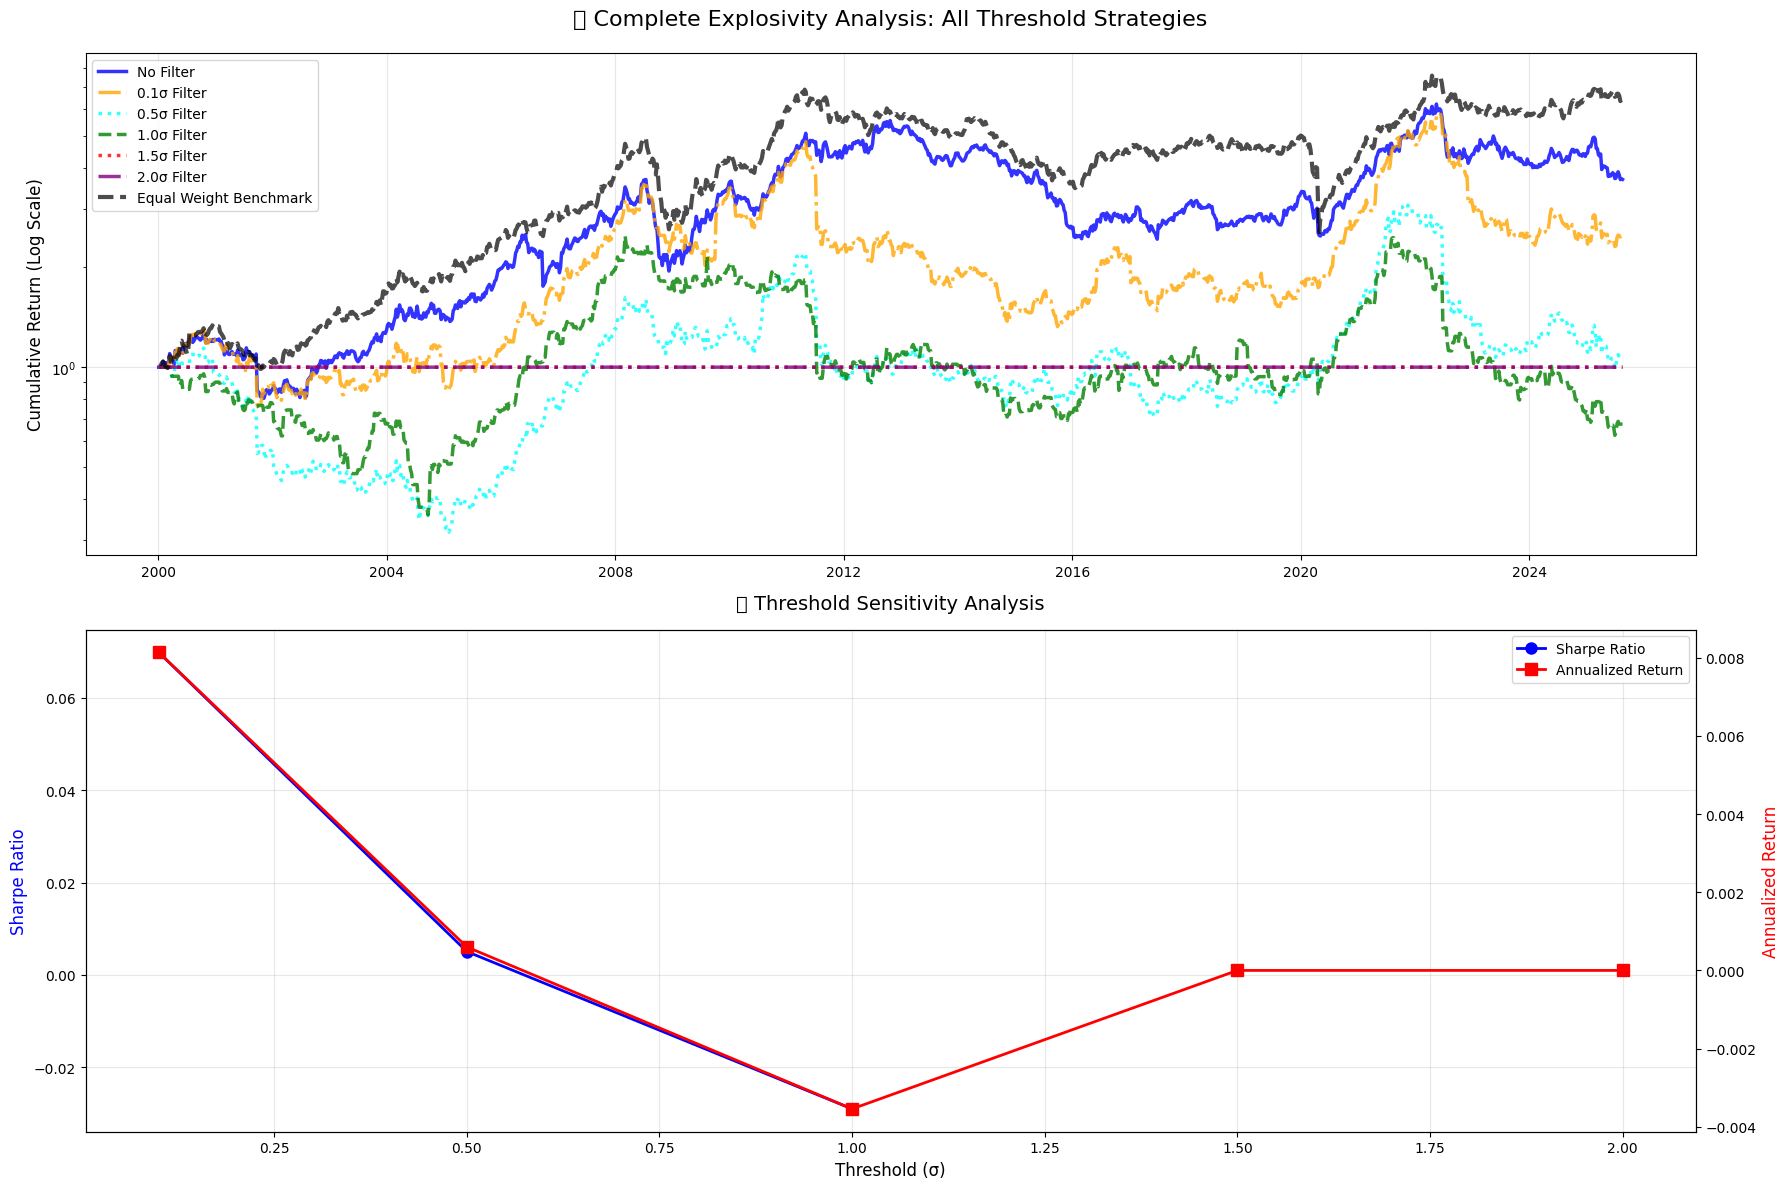

📈 COMPLETE ANALYSIS:
   • Top: All strategy equity curves
   • Bottom: Threshold sensitivity (Sharpe & Return)
   • Total strategies tested: 6


In [46]:
# 📈 COMPREHENSIVE Equity Curves: ALL 6 Strategies
plt.figure(figsize=(18, 12))

# Subplot principale per equity curves
ax1 = plt.subplot(2, 1, 1)

# Più colori per tutte le strategie
colors = ['blue', 'orange', 'cyan', 'green', 'red', 'purple']
linestyles = ['-', '-.', ':', '--', ':', '-.']

print(f"📊 Plotting {len(strategy_results)} strategies:")
for i, (strategy_name, results) in enumerate(strategy_results.items()):
    print(f"   {i+1}. {strategy_name}")
    cumulative = results['cumulative']
    
    # Usa modulo per evitare index error
    color_idx = i % len(colors)
    line_idx = i % len(linestyles)
    
    plt.plot(cumulative.index, cumulative.values, 
             label=strategy_name, linewidth=2.5, 
             color=colors[color_idx], linestyle=linestyles[line_idx],
             alpha=0.8)

# Benchmark
plt.plot(equal_weight_cumulative.index, equal_weight_cumulative.values, 
         label='Equal Weight Benchmark', linewidth=3, color='black', 
         linestyle='--', alpha=0.7)

plt.title('💥 Complete Explosivity Analysis: All Threshold Strategies', fontsize=16, pad=20)
plt.ylabel('Cumulative Return (Log Scale)', fontsize=12)
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, alpha=0.3)
plt.yscale('log')

# Subplot per trend dei threshold
ax2 = plt.subplot(2, 1, 2)

# Plot threshold sensitivity
if not filter_strategies.empty:
    thresholds_numeric = [0.1, 0.5, 1.0, 1.5, 2.0]
    sharpe_values = []
    return_values = []
    
    for threshold in thresholds_numeric:
        strategy_name = f"{threshold:.1f}σ Filter"
        if strategy_name in comparison_df.index:
            sharpe_values.append(comparison_df.loc[strategy_name, 'Sharpe_Ratio'])
            return_values.append(comparison_df.loc[strategy_name, 'Annualized_Return'])
        else:
            sharpe_values.append(np.nan)
            return_values.append(np.nan)
    
    ax2_twin = ax2.twinx()
    
    line1 = ax2.plot(thresholds_numeric, sharpe_values, 'o-', color='blue', linewidth=2, markersize=8, label='Sharpe Ratio')
    line2 = ax2_twin.plot(thresholds_numeric, return_values, 's-', color='red', linewidth=2, markersize=8, label='Annualized Return')
    
    ax2.set_xlabel('Threshold (σ)', fontsize=12)
    ax2.set_ylabel('Sharpe Ratio', fontsize=12, color='blue')
    ax2_twin.set_ylabel('Annualized Return', fontsize=12, color='red')
    ax2.set_title('🎯 Threshold Sensitivity Analysis', fontsize=14, pad=15)
    ax2.grid(True, alpha=0.3)
    
    # Combined legend
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax2.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()

print("📈 COMPLETE ANALYSIS:")
print("   • Top: All strategy equity curves")
print("   • Bottom: Threshold sensitivity (Sharpe & Return)")
print(f"   • Total strategies tested: {len(strategy_results)}")

📊 Plotting 6 strategies:
   1. No Filter
   2. 0.1σ Filter
   3. 0.5σ Filter
   4. 1.0σ Filter
   5. 1.5σ Filter
   6. 2.0σ Filter


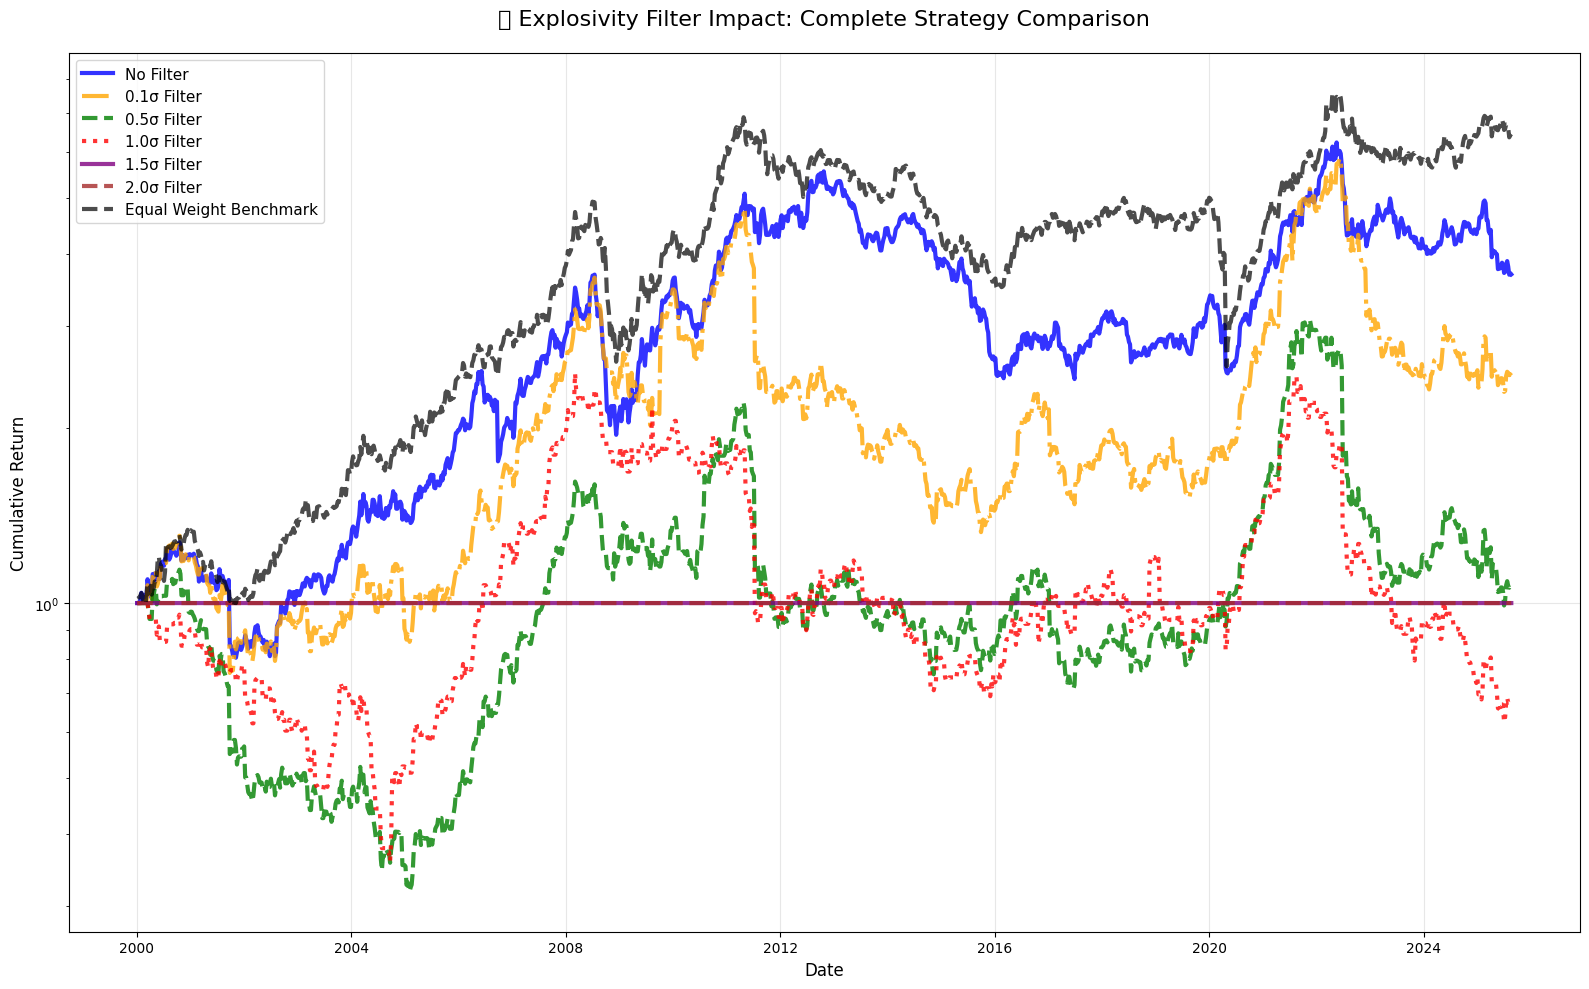

📈 EQUITY CURVES LEGEND:
   • Blue -: No Filter
   • Orange -.: 0.1σ Filter
   • Green --: 0.5σ Filter
   • Red :: 1.0σ Filter
   • Purple -: 1.5σ Filter
   • Brown --: 2.0σ Filter
   • Black dashed: Equal Weight Benchmark


In [47]:
# 📈 Equity Curves Comparison: ALL Strategies (FIXED)
plt.figure(figsize=(16, 10))

# Più colori e linestyles per gestire tutte le strategie
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
linestyles = ['-', '-.', '--', ':', '-', '--']

print(f"📊 Plotting {len(strategy_results)} strategies:")
for i, (strategy_name, results) in enumerate(strategy_results.items()):
    print(f"   {i+1}. {strategy_name}")
    cumulative = results['cumulative']
    
    # Usa modulo per evitare index error
    color_idx = i % len(colors)
    line_idx = i % len(linestyles)
    
    plt.plot(cumulative.index, cumulative.values, 
             label=strategy_name, linewidth=3, 
             color=colors[color_idx], linestyle=linestyles[line_idx],
             alpha=0.8)

# Benchmark
plt.plot(equal_weight_cumulative.index, equal_weight_cumulative.values, 
         label='Equal Weight Benchmark', linewidth=3, color='black', 
         linestyle='--', alpha=0.7)

plt.title('💥 Explosivity Filter Impact: Complete Strategy Comparison', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(fontsize=11, loc='upper left')
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

print("📈 EQUITY CURVES LEGEND:")
strategy_list = list(strategy_results.keys())
for i, strategy in enumerate(strategy_list):
    color_idx = i % len(colors)
    line_style = linestyles[i % len(linestyles)]
    print(f"   • {colors[color_idx].title()} {line_style}: {strategy}")
print("   • Black dashed: Equal Weight Benchmark")

IndexError: list index out of range

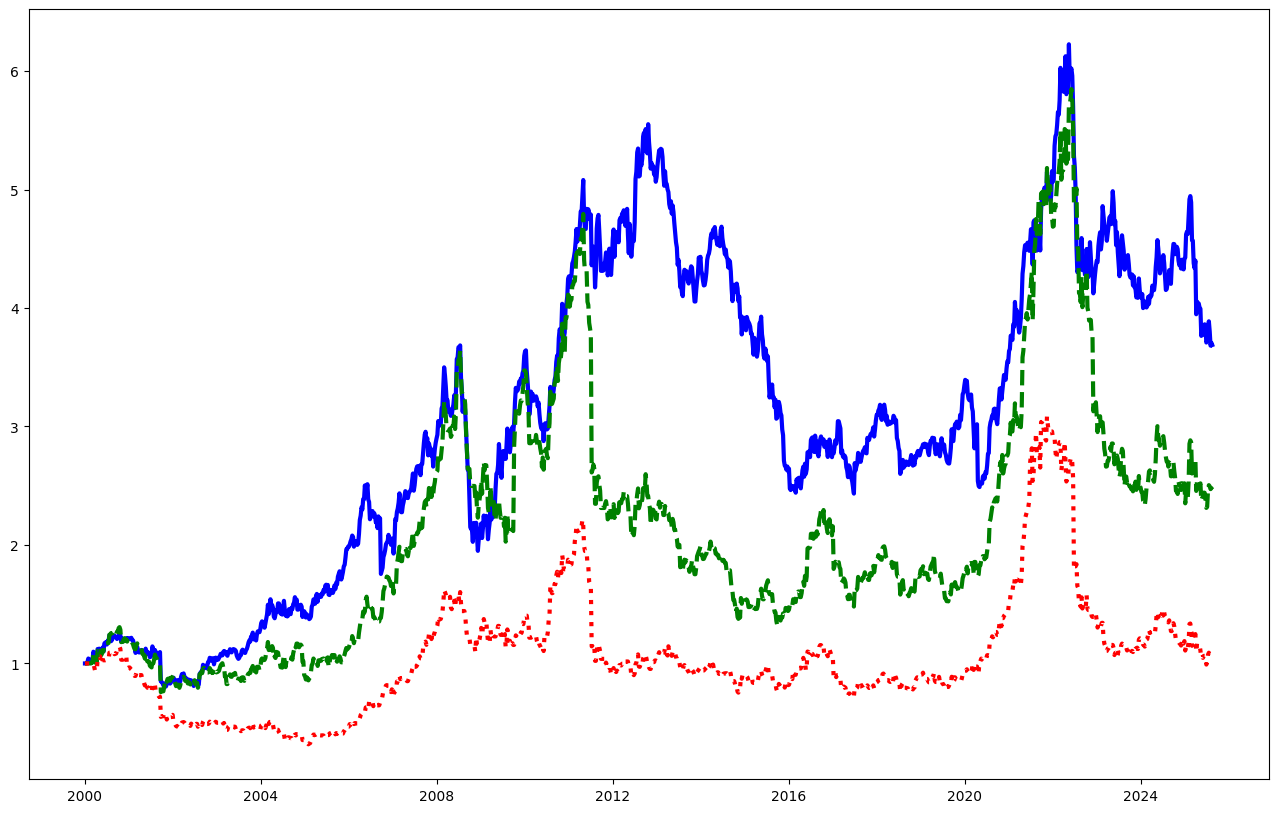

In [48]:
# 📈 Equity Curves Comparison: Filter Impact
plt.figure(figsize=(16, 10))

colors = ['blue', 'green', 'red']
linestyles = ['-', '--', ':']

for i, (strategy_name, results) in enumerate(strategy_results.items()):
    cumulative = results['cumulative']
    plt.plot(cumulative.index, cumulative.values, 
             label=strategy_name, linewidth=3, 
             color=colors[i], linestyle=linestyles[i])

# Benchmark
plt.plot(equal_weight_cumulative.index, equal_weight_cumulative.values, 
         label='Equal Weight Benchmark', linewidth=2, color='black', alpha=0.7)

plt.title('💥 Explosivity Filter Impact: Equity Curves Comparison', fontsize=16, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Return', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

print("📈 EQUITY CURVE INSIGHTS:")
print("   • Linea continua: No Filter")
print("   • Linea tratteggiata: 1.5σ Filter") 
print("   • Linea punteggiata: 2.0σ Filter")
print("   • Nero: Equal Weight Benchmark")